In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
from __future__ import division
import matplotlib
import numpy as np
from pylab import *
import os
import random as rnd
import subprocess
DEVNULL = open(os.devnull, 'wb')
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4)})
plotStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
np.seterr(divide='ignore',invalid='ignore')
pass

### Setup the notebook.

In [33]:
import h5py
import math
testNames=[
           "rdme_restart_1",
           "rdme_restart_2",
          ]
def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

In [34]:
%%bash
rm -rf tmp && mkdir tmp

### Execute the simulations.

In [35]:
def buildRestartFile(testname, filename, latticeShape):
    fp = h5py.File(filename, "a")
    trajectories = np.arange(1,11, dtype=np.uint64)
    fp.create_dataset("/Restart/Reaction/Trajectories", data=trajectories)
    if testname.endswith("_1"):
        times = np.zeros((trajectories.shape[0],), dtype=np.double)
        counts = np.zeros((trajectories.shape[0],3), dtype=np.int32)
        counts[:,0] = trajectories
        counts[:,1] = trajectories+20
        counts[:,2] = trajectories+40
        fp.create_dataset("/Restart/Reaction/Times", data=times)
        fp.create_dataset("/Restart/Reaction/SpeciesCounts", data=counts)
        createRestartLattice(fp, trajectories, latticeShape, counts)
    if testname.endswith("_2"):
        times = np.zeros((trajectories.shape[0],), dtype=np.double)
        times += trajectories*1e-3
        counts = np.zeros((trajectories.shape[0],3), dtype=np.int32)
        counts[:,0] = trajectories
        counts[:,1] = trajectories+20
        counts[:,2] = trajectories+40
        fp.create_dataset("/Restart/Reaction/Times", data=times)
        fp.create_dataset("/Restart/Reaction/SpeciesCounts", data=counts)
        createRestartLattice(fp, trajectories, latticeShape, counts)
    fp.close()
    return

In [36]:
def createRestartLattice(fp, trajectories, latticeShape, counts):
    for i,trajectory in enumerate(trajectories):
        lattice = 0xFF*np.ones(latticeShape, dtype=np.uint8)
        for j in range(counts.shape[1]):
            placed = 0
            while placed < counts[i,j]:
                x = rnd.randint(0,lattice.shape[0]-1)
                y = rnd.randint(0,lattice.shape[1]-1)
                z = rnd.randint(0,lattice.shape[2]-1)
                for p in range(lattice.shape[3]):
                    if lattice[x,y,z,p] == 0xFF:
                        lattice[x,y,z,p] = j
                        placed += 1
                        break
        fp.create_dataset("/Restart/Diffusion/Lattice/%d"%(i), data=lattice)
    return

In [37]:
sbmlFilename="second_order_reversible.sbml"

for testName in testNames:
    outputFilename = "tmp/%s.lm"%(testName)
    if os.path.isfile(outputFilename): os.remove(outputFilename)
    if (subprocess.call(["lm_sbml_import",outputFilename,sbmlFilename], stdout=DEVNULL, stderr=DEVNULL) != 0): print "Error: lm_sbml_import failed for %s"%(outputFilename)
    if (subprocess.call(["lm_setdm",outputFilename,"numberReactions=2","numberSpecies=3","numberSiteTypes=1","latticeSize=[5,6,7]","latticeSpacing=1e-6","particlesPerSite=16","DiffusionMatrix(0,0,:)=[1e-10,1e-10,1e-10]","ReactionLocationMatrix=[1,1]"], stdout=DEVNULL, stderr=DEVNULL) != 0): print "Error: lm_setdm failed for %s"%(outputFilename)
    if (subprocess.call(["lm_setp",outputFilename,"writeInterval=1e0","latticeWriteInterval=1e0","maxTime=1e1"], stdout=DEVNULL, stderr=DEVNULL) != 0): print "Error: lm_setp failed for %s"%(outputFilename)        
    buildRestartFile(testName, outputFilename, (5,6,7,16))
    with open("%s.simulate.log"%(outputFilename), "w") as logfile:
        if (subprocess.call(["lmes","-f",outputFilename,"-r","1-10","-sl","lm::rdme::NextSubvolumeSolver"], stdout=logfile, stderr=logfile) != 0): print "Error: lmes failed for %s"%(outputFilename)
print "Finished."

Finished.


### Spot check some simulations.

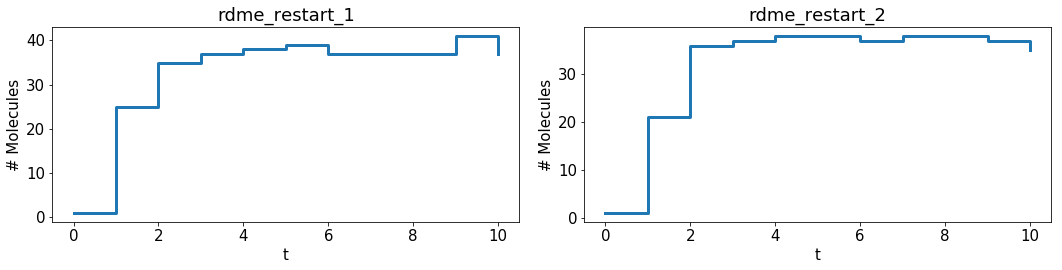

In [38]:
# Plot the time series for a single replicate.
for i,testName in enumerate(testNames):
    testOutputFilename="tmp/%s.lm"%(testName)
    fp = h5py.File(testOutputFilename, "r")
    cols=2
    rows=len(testNames)//cols
    if rows*cols < len(testNames): rows += 1
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,4*rows)})
    for replicate in (1,):
        counts=np.array(fp["/Simulations/%07d/SpeciesCounts"%replicate], dtype=double)
        times=np.array(fp["/Simulations/%07d/SpeciesCountTimes"%replicate], dtype=double)
        plt.subplot(rows,cols,i+1)
        step(times,counts[:,0], **stepStyles)
        xlabel('t'); ylabel('# Molecules'); title("%s"%(testName))
    fp.close()
plt.tight_layout()
pass

### Define the tests.

In [59]:
def test_rdme_restart_1(testOutputFilename):
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()
    k=0
    mSim=None
    vSim=None
    times=None
    for replicate in replicates:
        times = np.array(fp["/Simulations/%s/SpeciesCountTimes"%replicate], dtype=double)
        ltimes= np.array(fp["/Simulations/%s/LatticeTimes"%replicate], dtype=double)
        counts = np.array(fp["/Simulations/%s/SpeciesCounts"%replicate], dtype=double)
        for i in range(times.shape[0]):
            lfull = np.array(fp["/Simulations/%s/Lattice/%010d"%(replicate,i)], dtype=np.uint8)
            if i == 0:
                value = times[i]
                if  value != 0.0: raise Exception("incorrect value for time",i,value)
                value = counts[i,0]
                if  value != int(replicate): raise Exception("incorrect value for count",replicate,i,0,value)
                value = counts[i,1]
                if  value != int(replicate)+20: raise Exception("incorrect value for count",replicate,i,1,value)
                value = counts[i,2]
                if  value != int(replicate)+40: raise Exception("incorrect value for count",replicate,i,2,value)
                value = ltimes[i]
                if  value != 0.0: raise Exception("incorrect value for ltime",i,value)
                value = np.sum(lfull==0)
                if  value != counts[i,0]: raise Exception("incorrect value for lcount",replicate,i,0,value)
                value = np.sum(lfull==1)
                if  value != counts[i,1]: raise Exception("incorrect value for lcount",replicate,i,1,value)
                value = np.sum(lfull==2)
                if  value != counts[i,2]: raise Exception("incorrect value for lcount",replicate,i,2,value)
            else:
                value = times[i]
                if  value != i*1.0: raise Exception("incorrect value for time",i,value)
                value = counts[i,0]+counts[i,2]
                if  value != int(replicate)*2+40: raise Exception("incorrect value for count a",replicate,i,value)
                value = counts[i,1]+counts[i,2]
                if  value != int(replicate)*2+60: raise Exception("incorrect value for count b",replicate,i,value)
                value = ltimes[i]
                if  value != i*1.0: raise Exception("incorrect value for ltime",i,value)
                value = np.sum(lfull==0)
                if  value != counts[i,0]: raise Exception("incorrect value for lcount",replicate,i,0,value)
                value = np.sum(lfull==1)
                if  value != counts[i,1]: raise Exception("incorrect value for lcount",replicate,i,1,value)
                value = np.sum(lfull==2)
                if  value != counts[i,2]: raise Exception("incorrect value for lcount",replicate,i,2,value)
    return


In [62]:
def test_rdme_restart_2(testOutputFilename):
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()
    k=0
    mSim=None
    vSim=None
    times=None
    for replicate in replicates:
        times = np.array(fp["/Simulations/%s/SpeciesCountTimes"%replicate], dtype=double)
        ltimes= np.array(fp["/Simulations/%s/LatticeTimes"%replicate], dtype=double)
        counts = np.array(fp["/Simulations/%s/SpeciesCounts"%replicate], dtype=double)
        for i in range(times.shape[0]):
            lfull = np.array(fp["/Simulations/%s/Lattice/%010d"%(replicate,i)], dtype=np.uint8)
            if i == 0:
                value = times[i]
                if  value != int(replicate)*1e-3: raise Exception("incorrect value for time",i,value)
                value = counts[i,0]
                if  value != int(replicate): raise Exception("incorrect value for count",replicate,i,0,value)
                value = counts[i,1]
                if  value != int(replicate)+20: raise Exception("incorrect value for count",replicate,i,1,value)
                value = counts[i,2]
                if  value != int(replicate)+40: raise Exception("incorrect value for count",replicate,i,2,value)
                value = ltimes[i]
                if  value != int(replicate)*1e-3: raise Exception("incorrect value for ltime",i,value)
                value = np.sum(lfull==0)
                if  value != counts[i,0]: raise Exception("incorrect value for lcount",replicate,i,0,value)
                value = np.sum(lfull==1)
                if  value != counts[i,1]: raise Exception("incorrect value for lcount",replicate,i,1,value)
                value = np.sum(lfull==2)
                if  value != counts[i,2]: raise Exception("incorrect value for lcount",replicate,i,2,value)
            else:
                value = times[i]
                if  value != i*1.0: raise Exception("incorrect value for time",i,value)
                value = counts[i,0]+counts[i,2]
                if  value != int(replicate)*2+40: raise Exception("incorrect value for count a",replicate,i,value)
                value = counts[i,1]+counts[i,2]
                if  value != int(replicate)*2+60: raise Exception("incorrect value for count b",replicate,i,value)
                value = ltimes[i]
                if  value != i*1.0: raise Exception("incorrect value for ltime",i,value)
                value = np.sum(lfull==0)
                if  value != counts[i,0]: raise Exception("incorrect value for lcount",replicate,i,0,value)
                value = np.sum(lfull==1)
                if  value != counts[i,1]: raise Exception("incorrect value for lcount",replicate,i,1,value)
                value = np.sum(lfull==2)
                if  value != counts[i,2]: raise Exception("incorrect value for lcount",replicate,i,2,value)
    return


### Run the tests.

In [63]:
testMethods = {
               "rdme_restart_1": test_rdme_restart_1,
               "rdme_restart_2": test_rdme_restart_2,
              }
matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (20,5*len(testNames))})
i=1
for testName in testNames:
    try:
        testOutputFilename="tmp/%s.lm"%(testName)
        testMethods[testName](testOutputFilename)
    except Exception as e:
        print "%-60s : FAILED with:"%("["+testName+"]"),e
    except:
        print "%-60s : FAILED with: Unknown exception"%("["+testName+"]")
    else:
        print "%-60s : passed."%("["+testName+"]")
pass

[rdme_restart_1]                                             : passed.
[rdme_restart_2]                                             : passed.


In [64]:
%%bash
rm -rf tmp